In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mflex.simulate.simulate_boundary import dipole, dalmatian
from mflex.plot.plot_magnetogram import (
    plot_fieldlines_polar_paper,
    plot_fieldlines_polar_paper2,
    plot_fieldlines_dalmatian_paper,
    plot_fieldlines_grid,
)
from mflex.evaluate.metrics import (
    vec_corr_metric,
    vec_corr_metric2,
    cau_Schw_metric,
    cau_Schw_metric2,
    norm_vec_err_metric,
    norm_vec_err_metric2,
    mean_vec_err_metric,
    mean_vec_err_metric2,
    mag_ener_metric,
    mag_ener_metric2,
    field_div_metric,
    pearson_corr_coeff_comp,
)
from mflex.model.plasma_parameters import (
    bpressure,
    bdensity,
    btemp,
    deltapres,
    deltaden,
    pres,
    den,
    btemp,
)
from mflex.model.field.save import save_field, msatformat
from mflex.model.field.bfield_model import (
    magnetic_field,
    magnetic_field_hypergeo,
)
from mflex.model.field.utility.poloidal import (
    phi,
    phi_low,
    phi_hypgeo,
    dphidz_hypgeo,
    dphidz,
    dphidz_low,
)
from mflex.plot.plot_magnetogram import (
    plot_fieldlines_soar_paper,
    plot_fieldlines_soar_paper_zoom,
)
import matplotlib
from mflex.model.field.utility.height_profile import f_low, f

In [3]:
nresol_x = 200
nresol_y = 200
nresol_z = 400
xmin = 0.0
xmax = 2.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 2.0
zmin = 0.0
zmax = 2.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z
nf_max = 200
L = 1.0
print(xmin, ymin, zmin)
print(xmax, ymax, zmax)
print(pixelsize_x, pixelsize_y, pixelsize_z)

# Background atmosphere parameters
z0 = 0.2
deltaz = 0.02

b = 1.0

# Magnitc field parameters
z0_b = 0.2
deltaz_b = 0.02

a = 0.22
alpha = 0.25
a_low = a * (1 - np.tanh(-z0 / deltaz))
kappa = -np.log(a / a_low) / z0
kappa = 1 / z0


# Figure 1
z_arr: np.ndarray[np.float64, np.dtype[np.float64]] = (
    np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
)

f_const = np.zeros(nresol_z)
f_exp = np.zeros(nresol_z)
f_tanh = np.zeros(nresol_z)

for iz in range(0, nresol_z):
    z = z_arr[iz]
    f_const[iz] = a * (1 - np.tanh(-z0 / deltaz_b))
    f_exp[iz] = f_low(z, a_low, kappa)
    f_tanh[iz] = f(z, z0, deltaz, a, b)

0.0 0.0 0.0
2.0 2.0 2.0
0.01 0.01 0.005


In [4]:
from matplotlib import rc

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#cmap=000000-A8A8A8-FFFFFF
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

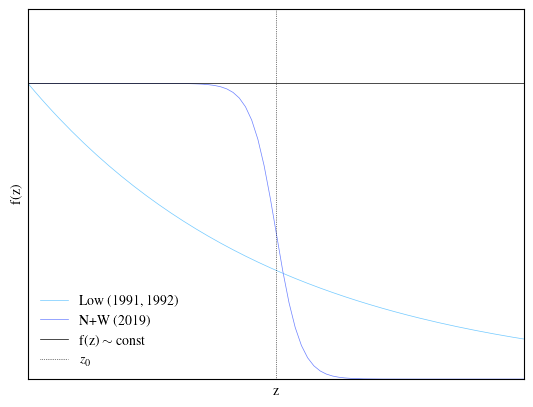

In [5]:
plt.plot(
    z_arr,
    f_exp,
    linewidth=0.5,
    color=c1,
    # linestyle="dashed",
    label=r"Low (1991, 1992)",
)
plt.plot(
    z_arr,
    f_tanh,
    linewidth=0.5,
    color=c2,
    # linestyle="solid",
    label=r"N+W (2019)",
)
plt.plot(
    z_arr,
    f_const,
    linewidth=0.5,
    color=c3,
    # linestyle="dotted",
    label=r"f(z) $\sim$ const",
)
plt.axvline(x=z0_b, color="black", linestyle="dotted", linewidth=0.5, label=r"$z_0$")
plt.legend(frameon=False)
plt.xlabel(r"z")
plt.ylabel(r"f(z)")
plt.xticks([])
plt.yticks([])
plt.xlim([0, 2 * z0])
plt.ylim([0, 2.5 * a])
# plotname = "/Users/lilli/Desktop/Thesis_vonNeu/heightprofiles.png"
# plt.savefig(plotname, dpi=300)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Thesis/heightprofiles.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight")
plt.show()

In [6]:
# Magnitc field parameters
z0_b = 0.2
deltaz_b = 0.02
a_low = a * (1 - np.tanh(-z0_b / deltaz_b))
kappa = -np.log(a / a_low) / z0_b
kappa = 1 / z0_b

a = 0.48
alpha = 0.3

length_scale = 1.0
length_scale_x = 1.0 * nresol_x * float(pixelsize_x)
length_scale_y = 1.0 * nresol_y * float(pixelsize_y)
length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]

one_arr = 0.0 * np.arange(nf_max) + 1.0
ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]
k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale) ** 2

ratiodzls = deltaz_b / length_scale
p_arr = 0.5 * ratiodzls * np.sqrt(k2_arr * (1.0 - a - a * b) - alpha**2)
q_arr = 0.5 * ratiodzls * np.sqrt(k2_arr * (1.0 - a + a * b) - alpha**2)

print(p_arr[20, 20])
print(q_arr[20, 20])

p_arr_low = 2.0 / kappa * np.sqrt(k2_arr - alpha**2)
q_arr_low = 2.0 / kappa * np.sqrt(k2_arr * a_low)

print(p_arr_low[20, 20])
print(q_arr_low[20, 20])

x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

0.08880700153068728
0.44427816514182555
17.77112660567302
11.788300542525711


In [7]:
phi_hyper = np.zeros((nresol_y, nresol_x, nresol_z))
phi_asymp = np.zeros((nresol_y, nresol_x, nresol_z))
phi_exp = np.zeros((nresol_y, nresol_x, nresol_z))

dphidz_exp = np.zeros((nresol_y, nresol_x, nresol_z))
dphidz_hyper = np.zeros((nresol_y, nresol_x, nresol_z))
dphidz_asymp = np.zeros((nresol_y, nresol_x, nresol_z))

for ix in range(nresol_x):
    for iy in range(nresol_y):
        p = p_arr[iy, ix]
        q = q_arr[iy, ix]
        p_low = p_arr_low[iy, ix]
        q_low = q_arr_low[iy, ix]
        for iz in range(nresol_z):
            z = z_arr[iz]
            phi_hyper[iy, ix, iz] = phi_hypgeo(z, p, q, z0_b, deltaz_b)
            phi_asymp[iy, ix, iz] = phi(z, p, q, z0_b, deltaz_b)
            #phi_exp[iy, ix, iz] = phi_low(z, p_low, q_low, kappa)

            dphidz_hyper[iy, ix, iz] = dphidz_hypgeo(z, p, q, z0_b, deltaz_b)
            dphidz_asymp[iy, ix, iz] = dphidz(z, p, q, z0_b, deltaz_b)
            #dphidz_exp[iy, ix, iz] = dphidz_low(z, p_low, q_low, kappa)

In [8]:
c4 = (1.000, 0.224, 0.376)

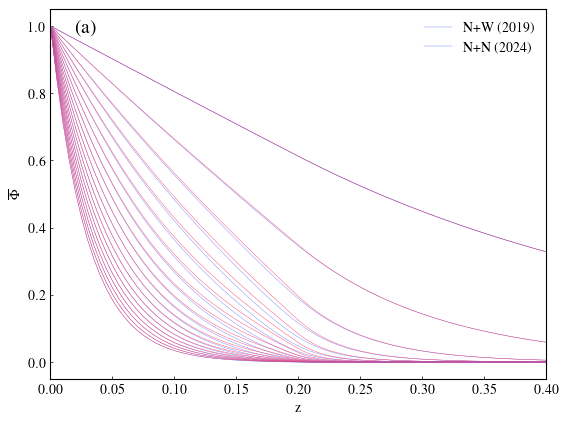

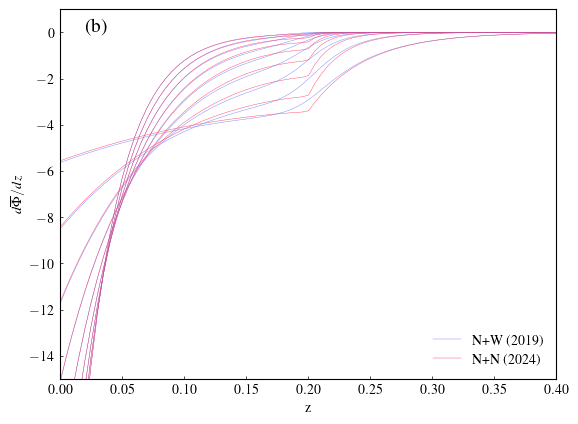

In [12]:
plt.plot(z_arr, phi_hyper[0, 0, :], linewidth=0.3, color=c2, label=r"N+W (2019)")
plt.plot(
    z_arr,
    phi_hyper[0, 0, :],
    linewidth=0.3,
    color=c2,
    label=r"N+N (2024)",
)
plt.plot(
    z_arr,
    phi_asymp[0, 0, :],
    linewidth=0.3,
    color=c4,
    # label="N+N (2024)",
    )
# plt.plot(
#     z_arr,
#     phi_exp[0, 0, :],
#     linewidth=0.3,
#     color=c1,
#     label=r"Low (1991, 1992)",
# )
for ix in range(4, 80, 4):
    plt.plot(
        z_arr,
        phi_hyper[ix, ix, :],
        linewidth=0.3,
        color=c2,
        # label="N+W (2019)"
    )
    plt.plot(
        z_arr,
        phi_asymp[ix, ix, :],
        linewidth=0.3,
        color=c4,
        # label="N+N (2024)",
    )
    # plt.plot(
    #     z_arr,
    #     phi_exp[ix, ix, :],
    #     linewidth=0.3,
    #     color=c1,
    #     # label="Low (1991, 1992)",
    # )
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel(r"z")
plt.ylabel(r"$\overline{\Phi}$")
plt.tick_params(direction="in", length=2, width=0.5)
plt.text(0.02, 0.98, "(a)", fontsize=14)
plotname = "/Users/lilli/Desktop/Paper/phi.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight")
plt.show()

plt.plot(
    z_arr,
    dphidz_hyper[10, 10, :],
    linewidth=0.3,
    color=c2,
    label=r"N+W (2019)",
)
plt.plot(
    z_arr,
    dphidz_asymp[10, 10, :],
    linewidth=0.3,
    color=c4,
    label=r"N+N (2024)",
)
# plt.plot(
#     z_arr,
#     dphidz_exp[10, 10, :],
#     linewidth=0.3,
#     color=c1,
#     label=r"Low (1991, 1992)",
# )
for ix in range(18, 80, 8):
    plt.plot(
        z_arr,
        dphidz_hyper[ix, ix, :],
        linewidth=0.3,
        color=c2,
        # label="N+W (2019)",
    )
    plt.plot(
        z_arr,
        dphidz_asymp[ix, ix, :],
        linewidth=0.3,
        color=c4,
        # label="N+N (2024)",
    )
    # plt.plot(
    #     z_arr,
    #     dphidz_exp[ix, ix, :],
    #     linewidth=0.3,
    #     color=c1,
    #     # label="Low (1991, 1992)",
    # )
plt.xlim([0, 2 * z0])
plt.ylim([-15, 1.0])
plt.legend(frameon=False)
plt.xlabel(r"z")
plt.ylabel(r"$d \overline{\Phi} / dz$")
plt.tick_params(direction="in", length=2, width=0.5)
plt.text(0.02, 0.0, "(b)", fontsize=14)
plotname = "/Users/lilli/Desktop/Paper/dphidz.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight")
plt.show()

In [4]:
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin

data_bz = np.zeros((nresol_y, nresol_x))

x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dalmatian(x, y)

In [ ]:
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin

x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(y_plot, x_plot, data_bz, 12, cmap=cmap, linewidths=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=6, inline=True)
ax.set_box_aspect(1)

ax.grid(False)

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

plt.tick_params(direction="in", length=2, width=0.5)

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
plt.text(0.02, 1.9, "(a)", fontsize=14)
plotname = "/Users/lilli/Desktop/Paper/contour1.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(y_plot, x_plot, data_bz, 12, colors="k", linewidths=0.3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=6, inline=True)
ax.set_box_aspect(1)
ax.grid(False)

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

plt.tick_params(direction="in", length=2, width=0.5)
plt.text(0.02, 1.9, "(a)", fontsize=14)
plotname = "/Users/lilli/Desktop/Paper/contour1b.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
from mflex.model.field.utility.seehafer import mirror_magnetogram

x_arr = np.arange(2.0 * nresol_x) * 2.0 * xmax / (2.0 * nresol_x - 1) - xmax
y_arr = np.arange(2.0 * nresol_y) * 2.0 * ymax / (2.0 * nresol_y - 1) - ymax
x_plot = np.outer(y_arr, np.ones(int(nresol_x * 2.0)))
y_plot = np.outer(x_arr, np.ones(int(nresol_y * 2.0))).T

data_bz_seehafer = mirror_magnetogram(
    data_bz, xmin, xmax, ymin, ymax, nresol_x, nresol_y
)

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(y_plot, x_plot, data_bz_seehafer, 12, cmap=cmap, linewidths=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=4, inline=True)
ax.set_box_aspect(1)

ax.grid(False)

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

plt.tick_params(direction="in", length=2, width=0.5)
plt.text(-1.95, 1.8, "(b)", fontsize=14)
plotname = "/Users/lilli/Desktop/Paper/contour2.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(y_plot, x_plot, data_bz_seehafer, 12, colors="k", linewidths=0.3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=4, inline=True)
ax.set_box_aspect(1)
ax.grid(False)

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

plt.tick_params(direction="in", length=2, width=0.5)
plt.text(-1.95, 1.8, "(b)", fontsize=14)
plotname = "/Users/lilli/Desktop/Paper/contour2b.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight")
plt.show()

In [10]:
# a_potential = 0.0
# alpha_potential = 0.0

# deltaz_b = 0.01

# mfield_asymp_potential, dmfield_asymp_potential = magnetic_field(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_potential,
#     b,
#     alpha_potential,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     length_scale,
# )

# mfield_hyp_potential, dmfield_hyp_potential = magnetic_field_hypergeo(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_potential,
#     b,
#     alpha_potential,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     length_scale,
# )

# save_field(mfield_asymp_potential, dmfield_asymp_potential, "potential_asymp")
# save_field(mfield_hyp_potential, dmfield_hyp_potential, "potential_hyp")

# # mfield_asymp_potential_dalmatian = np.load(
# #     f"/Users/lilli/Desktop/Paper/aBC_asymp_test_dalmatian_{a_potential}_{alpha_potential}_{b}_bfield3d.npy"
# # )
# # dmfield_asymp_potential_dalmatian = np.load(
# #     f"/Users/lilli/Desktop/Paper/aBC_asymp_test_dalmatian_{a_potential}_{alpha_potential}_{b}_dbzdxdydz3d.npy"
# # )

# a_lff = 0.0
# alpha_lff = 0.25

# mfield_asymp_lff, dmfield_asymp_lff = magnetic_field(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_lff,
#     b,
#     alpha_lff,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     length_scale,
# )

# mfield_hyp_lff, dmfield_hyp_lff = magnetic_field_hypergeo(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_lff,
#     b,
#     alpha_lff,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     length_scale,
# )

# save_field(mfield_asymp_lff, dmfield_asymp_lff, "lff_asymp")
# save_field(mfield_hyp_lff, dmfield_hyp_lff, "lff_hyp")

# mfield_asymp_lff_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_asymp_test_dalmatian_{a_lff}_{alpha_lff}_{b}_bfield3d.npy"
# )
# dmfield_asymp_lff_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_asymp_test_dalmatian_{a_lff}_{alpha_lff}_{b}_dbzdxdydz3d.npy"
# )

a_mhs1 = 0.22
alpha_mhs1 = 0.25

mfield_asymp_mhs1, dmfield_asymp_mhs1 = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a_mhs1,
    b,
    alpha_mhs1,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)

# mfield_hyp_mhs1, dmfield_hyp_mhs1 = magnetic_field_hypergeo(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_mhs1,
#     b,
#     alpha_mhs1,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     length_scale,
# )

# save_field(mfield_asymp_mhs1, dmfield_asymp_mhs1, "mhs1_asymp")
# save_field(mfield_hyp_mhs1, dmfield_hyp_mhs1, "mhs1_hyp")

# mfield_asymp_mhs1_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_asymp_test_dalmatian_{a_mhs1}_{alpha_mhs1}_{b}_bfield3d.npy"
# )
# dmfield_asymp_mhs1_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_asymp_test_dalmatian_{a_mhs1}_{alpha_mhs1}_{b}_dbzdxdydz3d.npy"
# )

# a_mhs2 = 0.44
# alpha_mhs2 = 0.25

# mfield_asymp_mhs2, dmfield_asymp_mhs2 = magnetic_field(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_mhs2,
#     b,
#     alpha_mhs2,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     length_scale,
# )

# mfield_hyp_mhs2, dmfield_hyp_mhs2 = magnetic_field_hypergeo(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_mhs2,
#     b,
#     alpha_mhs2,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     length_scale,
# )

# save_field(mfield_asymp_mhs2, dmfield_asymp_mhs2, "mhs2_asymp")
# save_field(mfield_hyp_mhs2, dmfield_hyp_mhs2, "mhs2_hyp")

# mfield_asymp_mhs2_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_asymp_test_dalmatian_{a_mhs2}_{alpha_mhs2}_{b}_bfield3d.npy"
# )
# dmfield_asymp_mhs2_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_asymp_test_dalmatian_{a_mhs2}_{alpha_mhs2}_{b}_dbzdxdydz3d.npy"
# )

0.01 0.01 200 200
length scale 2.0
length scale x 4.0
length scale y 4.0
length scale x norm 2.0
length scale y norm 2.0
xmin, xmax, ymin, ymax, zmin, zmax  0.0 2.0 0.0 2.0 0.0 2.0
xarr (400,)
y_arr (400,)
kx (200,)
ky (200,)
p_arr (200, 200)
q_arr (200, 200)
anm (200, 200)
phi (200, 200, 400)
dphi (200, 200, 400)


KeyboardInterrupt: 

In [ ]:
mfield_hyp_potential = np.load(f"/Users/lilli/Desktop/Paper/potential_hyp_bfield3d.npy")
dmfield_hyp_potential = np.load(
    f"/Users/lilli/Desktop/Paper/potential_hyp_dbzdxdydz3d.npy"
)


mfield_hyp_lff = np.load(f"/Users/lilli/Desktop/Paper/lff_hyp_bfield3d.npy")
dmfield_hyp_lff = np.load(f"/Users/lilli/Desktop/Paper/lff_hyp_dbzdxdydz3d.npy")

mfield_asymp_potential = np.load(
    f"/Users/lilli/Desktop/Paper/potential_asymp_bfield3d.npy"
)
dmfield_asymp_potential = np.load(
    f"/Users/lilli/Desktop/Paper/potential_asymp_dbzdxdydz3d.npy"
)


mfield_asymp_lff = np.load(f"/Users/lilli/Desktop/Paper/lff_asymp_bfield3d.npy")
dmfield_asymp_lff = np.load(f"/Users/lilli/Desktop/Paper/lff_asymp_dbzdxdydz3d.npy")


mfield_asymp_mhs1 = np.load(f"/Users/lilli/Desktop/Paper/mhs1_asymp_bfield3d.npy")
dmfield_asymp_mhs1 = np.load(f"/Users/lilli/Desktop/Paper/mhs1_asymp_dbzdxdydz3d.npy")

mfield_hyp_mhs1 = np.load(f"/Users/lilli/Desktop/Paper/mhs1_hyp_bfield3d.npy")
dmfield_hyp_mhs1 = np.load(f"/Users/lilli/Desktop/Paper/mhs1_hyp_dbzdxdydz3d.npy")


mfield_asymp_mhs2 = np.load(f"/Users/lilli/Desktop/Paper/mhs2_asymp_bfield3d.npy")
dmfield_asymp_mhs2 = np.load(f"/Users/lilli/Desktop/Paper/mhs2_asymp_dbzdxdydz3d.npy")

mfield_hyp_mhs2 = np.load(f"/Users/lilli/Desktop/Paper/mhs2_hyp_bfield3d.npy")
dmfield_hyp_mhs2 = np.load(f"/Users/lilli/Desktop/Paper/mhs2_hyp_dbzdxdydz3d.npy")

In [ ]:
a_potential = 0.0
alpha_potential = 0.0

a_lff = 0.0
alpha_lff = 0.25

a_mhs2 = 0.44
alpha_mhs2 = 0.25

a_mhs1 = 0.22
alpha_mhs1 = 0.25

In [ ]:
# mfield_hyp_potential_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_hypgeo_test_dalmatian_{a_potential}_{alpha_potential}_{b}_bfield3d.npy"
# )
# dmfield_hyp_potential_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_hypgeo_test_dalmatian_{a_potential}_{alpha_potential}_{b}_dbzdxdydz3d.npy"
# )


# mfield_hyp_lff_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_hypgeo_tes_dalmatian_{a_lff}_{alpha_lff}_{b}_bfield3d.npy"
# )
# dmfield_hyp_lff_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_hypgeo_tes_dalmatian_{a_lff}_{alpha_lff}_{b}_dbzdxdydz3d.npy"
# )


# mfield_hyp_mhs1_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_hypgeo_test_dalmatian_{a_mhs1}_{alpha_mhs1}_{b}_bfield3d.npy"
# )
# dmfield_hyp_mhs1_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_hypgeo_test_dalmatian_{a_mhs1}_{alpha_mhs1}_{b}_dbzdxdydz3d.npy"
# )


# mfield_hyp_mhs2_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_hypgeo_test_dalmatian_{a_mhs2}_{alpha_mhs2}_{b}_bfield3d.npy"
# )
# dmfield_hyp_mhs2_dalmatian = np.load(
#     f"/Users/lilli/Desktop/Paper/aBC_hypgeo_test_dalmatian_{a_mhs2}_{alpha_mhs2}_{b}_dbzdxdydz3d.npy"
# )

In [ ]:
h1 = L / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = L  # Maximum step length for fieldline3D

plot_fieldlines_dalmatian_paper(
    mfield_hyp_potential,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a_potential,
    b,
    alpha_potential,
    nf_max,
    name="MF_hyp_dalmatian",
    cmap=cmap,
    label="(a*)",
)

plot_fieldlines_dalmatian_paper(
    mfield_asymp_potential,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a_potential,
    b,
    alpha_potential,
    nf_max,
    name="MF_asymp_dalmatian",
    cmap=cmap,
    label="(a)",
)

plot_fieldlines_dalmatian_paper(
    mfield_hyp_lff,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a_lff,
    b,
    alpha_lff,
    nf_max,
    name="MF_hyp_dalmatian",
    cmap=cmap,
    label="(b*)",
)

plot_fieldlines_dalmatian_paper(
    mfield_asymp_lff,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a_lff,
    b,
    alpha_lff,
    nf_max,
    name="MF_asymp_dalmatian",
    cmap=cmap,
    label="(b)",
)

plot_fieldlines_dalmatian_paper(
    mfield_hyp_mhs1,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a_mhs1,
    b,
    alpha_mhs1,
    nf_max,
    name="MF_hyp_dalmatian",
    cmap=cmap,
    label="(c*)",
)

plot_fieldlines_dalmatian_paper(
    mfield_asymp_mhs1,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a_mhs1,
    b,
    alpha_mhs1,
    nf_max,
    name="MF_asymp_dalmatian",
    cmap=cmap,
    label="(c)",
)

plot_fieldlines_dalmatian_paper(
    mfield_hyp_mhs2,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a_mhs2,
    b,
    alpha_mhs2,
    nf_max,
    name="MF_hyp_dalmatian",
    cmap=cmap,
    label="(d*)",
)

plot_fieldlines_dalmatian_paper(
    mfield_asymp_mhs2,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a_mhs2,
    b,
    alpha_mhs2,
    nf_max,
    name="MF_asymp_dalmatian",
    cmap=cmap,
    label="(d)",
)

In [ ]:
print(np.unravel_index(data_bz.argmax(), data_bz.shape))
ix_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[1]
iy_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[0]
print(np.unravel_index(mfield_asymp_mhs1.argmax(), mfield_asymp_mhs1.shape))

In [ ]:
# dpres_hyp_mhs2 = np.zeros((nresol_y, nresol_x, nresol_z))
# dpres_asymp_mhs2 = np.zeros((nresol_y, nresol_x, nresol_z))

# dden_hyp_mhs2 = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_asymp_mhs2 = np.zeros((nresol_y, nresol_x, nresol_z))

# dpres_hyp_mhs1 = np.zeros((nresol_y, nresol_x, nresol_z))
# dpres_asymp_mhs1 = np.zeros((nresol_y, nresol_x, nresol_z))

# dden_hyp_mhs1 = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_asymp_mhs1 = np.zeros((nresol_y, nresol_x, nresol_z))

# dpres_asymp_lff = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_asymp_lff = np.zeros((nresol_y, nresol_x, nresol_z))

# dpres_asymp_potential = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_asymp_potential = np.zeros((nresol_y, nresol_x, nresol_z))

# for ix in range(nresol_x):
#     for iy in range(nresol_y):
#         for iz in range(nresol_z):
#             z = z_arr[iz]
#             bz_hyp_mhs2 = mfield_hyp_mhs2[nresol_y + iy, nresol_x + ix, iz, 2]
#             bz_asymp_mhs2 = mfield_asymp_mhs2[nresol_y + iy, nresol_x + ix, iz, 2]

#             dbz_hyp_mhs2 = (
#                 dmfield_hyp_mhs2[nresol_y + iy, nresol_x + ix, iz, 1]
#                 * mfield_hyp_mhs2[nresol_y + iy, nresol_x + ix, iz, 1]
#                 + dmfield_hyp_mhs2[nresol_y + iy, nresol_x + ix, iz, 0]
#                 * mfield_hyp_mhs2[nresol_y + iy, nresol_x + ix, iz, 0]
#                 + dmfield_hyp_mhs2[nresol_y + iy, nresol_x + ix, iz, 2]
#                 * mfield_hyp_mhs2[nresol_y + iy, nresol_x + ix, iz, 2]
#             )
#             dbz_asymp_mhs2 = (
#                 dmfield_asymp_mhs2[nresol_y + iy, nresol_x + ix, iz, 1]
#                 * mfield_asymp_mhs2[nresol_y + iy, nresol_x + ix, iz, 1]
#                 + dmfield_asymp_mhs2[nresol_y + iy, nresol_x + ix, iz, 0]
#                 * mfield_asymp_mhs2[nresol_y + iy, nresol_x + ix, iz, 0]
#                 + dmfield_asymp_mhs2[nresol_y + iy, nresol_x + ix, iz, 2]
#                 * mfield_asymp_mhs2[nresol_y + iy, nresol_x + ix, iz, 2]
#             )
#             dpres_hyp_mhs2[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a_mhs2, b, bz_hyp_mhs2)
#             dpres_asymp_mhs2[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a_mhs2, b, bz_asymp_mhs2)

#             dden_hyp_mhs2[iy, ix, iz] = deltaden(
#                 z, z0_b, deltaz_b, a_mhs2, b, bz_hyp_mhs2, dbz_hyp_mhs2
#             )
#             dden_asymp_mhs2[iy, ix, iz] = deltaden(
#                 z, z0_b, deltaz_b, a_mhs2, b, bz_asymp_mhs2, dbz_asymp_mhs2
#             )

#             bz_asymp_potential = mfield_asymp_potential[nresol_y + iy, nresol_x + ix, iz, 2]

#             dbz_asymp_potential = (
#                 dmfield_asymp_potential[nresol_y + iy, nresol_x + ix, iz, 1]
#                 * mfield_asymp_potential[nresol_y + iy, nresol_x + ix, iz, 1]
#                 + dmfield_asymp_potential[nresol_y + iy, nresol_x + ix, iz, 0]
#                 * mfield_asymp_potential[nresol_y + iy, nresol_x + ix, iz, 0]
#                 + dmfield_asymp_potential[nresol_y + iy, nresol_x + ix, iz, 2]
#                 * mfield_asymp_potential[nresol_y + iy, nresol_x + ix, iz, 2]
#             )

#             dpres_asymp_potential[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a_potential, b, bz_asymp_potential)

#             dden_asymp_potential[iy, ix, iz] = deltaden(
#                 z, z0_b, deltaz_b, a_potential, b, bz_asymp_potential, dbz_asymp_potential
#             )

#             bz_asymp_lff = mfield_asymp_lff[nresol_y + iy, nresol_x + ix, iz, 2]

#             dbz_asymp_lff = (
#                 dmfield_asymp_lff[nresol_y + iy, nresol_x + ix, iz, 1]
#                 * mfield_asymp_lff[nresol_y + iy, nresol_x + ix, iz, 1]
#                 + dmfield_asymp_lff[nresol_y + iy, nresol_x + ix, iz, 0]
#                 * mfield_asymp_lff[nresol_y + iy, nresol_x + ix, iz, 0]
#                 + dmfield_asymp_lff[nresol_y + iy, nresol_x + ix, iz, 2]
#                 * mfield_asymp_lff[nresol_y + iy, nresol_x + ix, iz, 2]
#             )

#             dpres_asymp_lff[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a_lff, b, bz_asymp_lff)

#             dden_asymp_lff[iy, ix, iz] = deltaden(
#                 z, z0_b, deltaz_b, a_lff, b, bz_asymp_lff, dbz_asymp_lff
#             )

#             bz_hyp_mhs1 = mfield_hyp_mhs1[nresol_y + iy, nresol_x + ix, iz, 2]
#             bz_asymp_mhs1 = mfield_asymp_mhs1[nresol_y + iy, nresol_x + ix, iz, 2]

#             dbz_hyp_mhs1 = (
#                 dmfield_hyp_mhs1[nresol_y + iy, nresol_x + ix, iz, 1]
#                 * mfield_hyp_mhs1[nresol_y + iy, nresol_x + ix, iz, 1]
#                 + dmfield_hyp_mhs1[nresol_y + iy, nresol_x + ix, iz, 0]
#                 * mfield_hyp_mhs1[nresol_y + iy, nresol_x + ix, iz, 0]
#                 + dmfield_hyp_mhs1[nresol_y + iy, nresol_x + ix, iz, 2]
#                 * mfield_hyp_mhs1[nresol_y + iy, nresol_x + ix, iz, 2]
#             )
#             dbz_asymp_mhs1 = (
#                 dmfield_asymp_mhs1[nresol_y + iy, nresol_x + ix, iz, 1]
#                 * mfield_asymp_mhs1[nresol_y + iy, nresol_x + ix, iz, 1]
#                 + dmfield_asymp_mhs1[nresol_y + iy, nresol_x + ix, iz, 0]
#                 * mfield_asymp_mhs1[nresol_y + iy, nresol_x + ix, iz, 0]
#                 + dmfield_asymp_mhs1[nresol_y + iy, nresol_x + ix, iz, 2]
#                 * mfield_asymp_mhs1[nresol_y + iy, nresol_x + ix, iz, 2]
#             )
#             dpres_hyp_mhs1[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a_mhs1, b, bz_hyp_mhs1)
#             dpres_asymp_mhs1[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a_mhs1, b, bz_asymp_mhs1)

#             dden_hyp_mhs1[iy, ix, iz] = deltaden(
#                 z, z0_b, deltaz_b, a_mhs1, b, bz_hyp_mhs1, dbz_hyp_mhs1
#             )
#             dden_asymp_mhs1[iy, ix, iz] = deltaden(
#                 z, z0_b, deltaz_b, a_mhs1, b, bz_asymp_mhs1, dbz_asymp_mhs1
#             )

In [ ]:
# np.save("/Users/lilli/Desktop/Paper/dden_hyp_mhs1", dden_hyp_mhs1)
# np.save("/Users/lilli/Desktop/Paper/dden_asymp_mhs1", dden_asymp_mhs1)

# np.save("/Users/lilli/Desktop/Paper/dden_hyp_mhs2", dden_hyp_mhs2)
# np.save("/Users/lilli/Desktop/Paper/dden_asymp_mhs2", dden_asymp_mhs2)

# np.save("/Users/lilli/Desktop/Paper/dpres_hyp_mhs1", dpres_hyp_mhs1)
# np.save("/Users/lilli/Desktop/Paper/dpres_asymp_mhs1", dpres_asymp_mhs1)

# np.save("/Users/lilli/Desktop/Paper/dpres_hyp_mhs2", dpres_hyp_mhs2)
# np.save("/Users/lilli/Desktop/Paper/dpres_asymp_mhs2", dpres_asymp_mhs2)

# np.save("/Users/lilli/Desktop/Paper/dpres_asymp_lff", dpres_asymp_lff)
# np.save("/Users/lilli/Desktop/Paper/dden_asymp_lff", dden_asymp_lff)

# np.save("/Users/lilli/Desktop/Paper/dpres_asymp_potential", dpres_asymp_potential)
# np.save("/Users/lilli/Desktop/Paper/dden_asymp_potential", dden_asymp_potential)

In [ ]:
dden_hyp_mhs1 = np.load("/Users/lilli/Desktop/Paper/dden_hyp_mhs1.npy")
dden_asymp_mhs1 = np.load("/Users/lilli/Desktop/Paper/dden_asymp_mhs1.npy")

dden_hyp_mhs2 = np.load("/Users/lilli/Desktop/Paper/dden_hyp_mhs2.npy")
dden_asymp_mhs2 = np.load("/Users/lilli/Desktop/Paper/dden_asymp_mhs2.npy")

dpres_hyp_mhs1 = np.load("/Users/lilli/Desktop/Paper/dpres_hyp_mhs1.npy")
dpres_asymp_mhs1 = np.load("/Users/lilli/Desktop/Paper/dpres_asymp_mhs1.npy")

dpres_hyp_mhs2 = np.load("/Users/lilli/Desktop/Paper/dpres_hyp_mhs2.npy")
dpres_asymp_mhs2 = np.load("/Users/lilli/Desktop/Paper/dpres_asymp_mhs2.npy")

dpres_asymp_lff = np.load("/Users/lilli/Desktop/Paper/dpres_asymp_lff.npy")
dden_asymp_lff = np.load("/Users/lilli/Desktop/Paper/dden_asymp_lff.npy")

dpres_asymp_potential = np.load("/Users/lilli/Desktop/Paper/dpres_asymp_potential.npy")
dden_asymp_potential = np.load("/Users/lilli/Desktop/Paper/dden_asymp_potential.npy")

In [ ]:
plt.plot(
    z_arr,
    dpres_asymp_lff[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    z_arr,
    dpres_asymp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="Low-a MHS",
)
plt.plot(
    z_arr,
    dpres_hyp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="Low-a MHS (N+W(2019))",
)
plt.plot(
    z_arr,
    dpres_asymp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dpres_hyp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="High-a MHS (N+W(2019))",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/dpres_cases.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    z_arr,
    dpres_asymp_lff[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    z_arr,
    dpres_asymp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="Low-a MHS",
)
plt.plot(
    z_arr,
    dpres_hyp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="Low-a MHS (N+W(2019))",
)
plt.plot(
    z_arr,
    dpres_asymp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dpres_hyp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="High-a MHS (N+W(2019))",
)
plt.xlim([0, 0.25])
plt.ylim([-0.6, 0])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/dpres_cases2.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()


plt.plot(
    z_arr,
    dden_asymp_lff[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    z_arr,
    dden_asymp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="Low-a MHS",
)
plt.plot(
    z_arr,
    dden_hyp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="Low-a MHS (N+W(2019))",
)
plt.plot(
    z_arr,
    dden_asymp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dden_hyp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="High-a MHS (N+W(2019))",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/dden_cases.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    z_arr,
    dden_asymp_lff[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    z_arr,
    dden_asymp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="Low-a MHS",
)
plt.plot(
    z_arr,
    dden_hyp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="Low-a MHS (N+W(2019))",
)
plt.plot(
    z_arr,
    dden_asymp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dden_hyp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="High-a MHS (N+W(2019))",
)
plt.xlim([0, 0.25])
plt.ylim([-6, 0])
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/dden_cases2.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [5]:
c5 = (1.000, 0.412, 0.816)

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(
    z_arr,
    dpres_asymp_lff[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label=r"$\Delta p$ LFF",
)
ax1.plot(
    z_arr,
    dpres_asymp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label=r"$\Delta p$ Low-a MHS",
)
ax1.plot(
    z_arr,
    dpres_hyp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label=r"$\Delta p$ Low-a MHS (N+W(2019))",
)
ax1.plot(
    z_arr,
    dpres_asymp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c5,
    label=r"$\Delta p$ High-a MHS",
)
ax1.plot(
    z_arr,
    dpres_hyp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c5,
    label=r"$\Delta p$ High-a MHS (N+W(2019))",
)
ax1.set_ylabel(r"$\Delta p$")

ax2 = ax1.twinx()

ax2.plot(
    z_arr,
    dden_asymp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c1,
    label=r"$\Delta \rho$ Low-a MHS",
)
ax2.plot(
    z_arr,
    dden_hyp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c1,
    label=r"$\Delta \rho$ Low-a MHS (N+W(2019))",
)
ax2.plot(
    z_arr,
    dden_asymp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label=r"$\Delta \rho$ High-a MHS",
)
ax2.plot(
    z_arr,
    dden_hyp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label=r"$\Delta \rho$ High-a MHS (N+W(2019))",
)
ax2.set_ylabel(r"$\Delta \rho$")

plt.xlim([0, 2 * z0])
ax1.set_xlabel("z")
ax1.legend(frameon=False, loc="center right")
ax2.legend(frameon=False)
ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/plasmaparam.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(
    z_arr,
    dpres_asymp_lff[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label=r"$\Delta p$, $\Delta \rho$ LFF",
)
ax1.plot(
    z_arr,
    dpres_asymp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label=r"$\Delta p$ Low-a MHS",
)
ax1.plot(
    z_arr,
    dpres_hyp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label=r"$\Delta p$ Low-a MHS (N+W(2019))",
)
ax1.plot(
    z_arr,
    dpres_asymp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c5,
    label=r"$\Delta p$ High-a MHS",
)
ax1.plot(
    z_arr,
    dpres_hyp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c5,
    label=r"$\Delta p$ igh-a MHS (N+W(2019))",
)
ax1.set_ylabel(r"$\Delta p$")

ax2 = ax1.twinx()

ax2.plot(
    z_arr,
    dden_asymp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c1,
    label=r"$\Delta \rho$ Low-a MHS",
)
ax2.plot(
    z_arr,
    dden_hyp_mhs1[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c1,
    label=r"$\Delta \rho$ Low-a MHS (N+W(2019))",
)
ax2.plot(
    z_arr,
    dden_asymp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label=r"$\Delta \rho$ High-a MHS",
)
ax2.plot(
    z_arr,
    dden_hyp_mhs2[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label=r"$\Delta \rho$ High-a MHS (N+W(2019))",
)
ax2.set_ylabel(r"$\Delta \rho$")

plt.xlim([0, 0.25])
ax1.set_ylim([-0.6875, 0])
ax2.set_ylim([-6.875, 0])
ax1.set_xlabel("z")
# ax1.legend(frameon=False, loc='center right')
# ax2.legend(frameon=False)
ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/plasmaparam2.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
bfield_bx_rec = mfield_asymp_mhs2[
    nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1
]
bfield_by_rec = mfield_asymp_mhs2[
    nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0
]
bfield_bz_rec = mfield_asymp_mhs2[
    nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2
]

bfield_bx_ref = mfield_hyp_mhs2[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by_ref = mfield_hyp_mhs2[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz_ref = mfield_hyp_mhs2[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]

B_rec = np.array((bfield_by_rec, bfield_bx_rec, bfield_bz_rec))
B_ref = np.array((bfield_by_ref, bfield_bx_ref, bfield_bz_ref))

print("Vec Corr2", vec_corr_metric2(B_ref, B_rec))
# print("Ref", vec_corr_metric2(B_ref, B_ref))
print("Cau Schw2", cau_Schw_metric2(B_ref, B_rec))
# print("Ref", cau_Schw_metric2(B_ref, B_ref))
print("Norm err2", norm_vec_err_metric2(B_ref, B_rec))
# print("Ref", norm_vec_err_metric2(B_ref, B_ref))
print("Mean err2", mean_vec_err_metric2(B_ref, B_rec))
# print("Ref", mean_vec_err_metric2(B_ref, B_ref))
print("Mag ener2", mag_ener_metric2(B_ref, B_rec))
# print("Ref", mag_ener_metric2(B_ref, B_ref))

In [ ]:
deltaz_arr = np.array((0.01, 0.02, 0.04, 0.1))

VC_arr_mhs1 = np.array((0.9999998, 0.9999982, 0.9999857, 0.9998128))
CS_arr_mhs1 = np.array((0.9999999, 0.9999998, 0.9999983, 0.9999825))

VC_arr_mhs2 = np.array((0.9999979, 0.9999827, 0.9998503, 0.99981756))
CS_arr_mhs2 = np.array((0.99999998, 0.99999987, 0.9999891, 0.9998825))

MagEn_arr_mhs2 = np.array((0.9993600, 0.9975977, 0.9914306, 0.9665598))
MagEn_arr_mhs1 = np.array((0.9999344, 0.9997545, 0.9990861, 0.996007))

NErr_arr_mhs1 = np.array((0.0003067, 0.0011059, 0.0037774, 0.0154657))
MErr_arr_mhs1 = np.array((0.0001014, 0.0003774, 0.0013637, 0.0068404))
NErr_arr_mhs2 = np.array((0.0009797, 0.0035126, 0.0117526, 0.0447817))
MErr_arr_mhs2 = np.array((0.0002559, 0.0009407, 0.0033072, 0.0155048))

In [ ]:
c5 = (1.000, 0.000, 0.773)


c6 = (1.000, 0.780, 0.000)
c7 = (0.443, 1.000, 0.855)
c8 = (0.996, 1.000, 0.000)

c9 = (0.671, 0.714, 1.000)

In [ ]:
c5

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(
    deltaz_arr,
    VC_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c1,
    label="VecCorr l-a",
)
ax1.plot(
    deltaz_arr,
    VC_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(0.000, 0.365, 0.580),
    label="VecCorr h-a",
)

ax1.plot(
    deltaz_arr,
    CS_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.831, 0.514),
    label="CSchw l-a",
)
ax1.plot(
    deltaz_arr,
    CS_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.537, 0.000),
    label="CSchw h-a",
)


ax1.set_ylabel("VecCorr, CSchw")

ax1.set_xlabel(r"$\Delta z$")

ax2 = ax1.twinx()

ax2.plot(
    deltaz_arr,
    NErr_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c9,
    label="NErr l-a",
)
ax2.plot(
    deltaz_arr,
    NErr_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c2,
    label="NErr h-a",
)

ax2.plot(
    deltaz_arr,
    MErr_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.533, 0.627),
    label="MErr l-a",
)
ax2.plot(
    deltaz_arr,
    MErr_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c4,
    label="MErr h-a",
)

ax2.set_ylabel("NErr, MErr")

ax3 = ax1.twinx()

ax3.plot(
    deltaz_arr,
    MagEn_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.514, 0.890),
    label="MagEn l-a",
)
ax3.plot(
    deltaz_arr,
    MagEn_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c5,
    label="MagEn h-a",
)
ax3.spines["right"].set_position(("outward", 50))

ax3.set_ylabel("MagEn")
# ax1.legend(frameon=False, loc='center left', bbox_to_anchor=(1.1, 0.8))
# ax2.legend(frameon=False, loc ='center left', bbox_to_anchor=(1.1, 0.55))
# ax3.legend(frameon=False, loc ='center left', bbox_to_anchor=(1.1, 0.35))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines = lines1 + lines2 + lines3
labels = labels1 + labels2 + labels3
plt.legend(lines, labels, frameon=False, loc="center left", bbox_to_anchor=(1.25, 0.5))

ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
ax3.tick_params(direction="in", length=2, width=0.5)

plotname = "/Users/lilli/Desktop/Paper/metrics.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
print(
    "Field line",
    field_div_metric(
        mfield_hyp_mhs1,
        mfield_asymp_mhs1,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.05,
    ),
)
print(
    "Ref",
    field_div_metric(
        mfield_hyp_mhs1,
        mfield_hyp_mhs1,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.05,
    ),
)

In [ ]:
t_photosphere = 5600.0
t_corona = 2.0 * 10.0**6
t0 = (t_photosphere + t_corona * np.tanh(z0 / deltaz)) / (1.0 + np.tanh(z0 / deltaz))
t1 = (t_corona - t_photosphere) / (1.0 + np.tanh(z0 / deltaz))
L = 1.0
g_solar = 272.2  # kg/m^3
kB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass)
h = (
    kB * t0 / (mbar * g_solar) * 10**-6 / L  # h' = h / L
)  # pressure scale height in normalised length scale (10**-6 to convert to Mm, and L**-1 to convert to normalised length scale)
rho0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
b0 = 500.0  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
p0 = t_photosphere * kB * rho0 / mbar  # plasma pressure in kg/(s^2 m)
mu0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)
pB0 = (b0 * 10**-4) ** 2 / (2 * mu0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
beta0 = p0 / pB0  # Plasma Beta, ration plasma to magnetic pressure
h_photo = h / t0 * t_photosphere

backpres = 0.0 * z_arr
backden = 0.0 * z_arr

for iz in range(nresol_z):
    z = z_arr[iz]
    backpres[iz] = bpressure(z, z0, deltaz, h, t0, t1)
    backden[iz] = bdensity(z, z0, deltaz, h, t0, t1)

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_asymp_lff[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label=r"$p, \rho$ LFF",
)
ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_asymp_mhs1[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label=r"$p$ Low-a MHS",
)
ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_hyp_mhs1[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label=r"$p$ Low-a MHS (N+W(2019))",
)
ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_asymp_mhs2[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="solid",
    color=c5,
    label=r"$p$ High-a MHS",
)
ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_hyp_mhs2[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="dashed",
    color=c5,
    label=r"$p$ High-a MHS (N+W(2019))",
)
ax1.set_ylabel(r"$p$")

ax2 = ax1.twinx()

ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_asymp_lff[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="dashed",
    color=c3,
    label=r"$\rho$ LFF",
)
ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_asymp_mhs1[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="solid",
    color=c1,
    label=r"$\rho$ Low-a MHS",
)
ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_hyp_mhs1[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="dashed",
    color=c1,
    label=r"$\rho$ Low-a MHS (N+W(2019))",
)
ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_asymp_mhs2[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label=r"$\rho$ High-a MHS",
)
ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_hyp_mhs2[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label=r"$\rho$ High-a MHS (N+W(2019))",
)
ax2.set_ylabel(r"$\rho$")

plt.xlim([0, 2 * z0])
ax1.set_xlabel("z")
ax1.legend(frameon=False, loc="upper right")
ax2.legend(frameon=False, loc="center right")
ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/plasmaparamfull.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_asymp_lff[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label=r"$p, \rho$ LFF",
)
ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_asymp_mhs1[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label=r"$p$ Low-a MHS",
)
ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_hyp_mhs1[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label=r"$p$ Low-a MHS (N+W(2019))",
)
ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_asymp_mhs2[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="solid",
    color=c5,
    label=r"$p$ High-a MHS",
)
ax1.plot(
    z_arr,
    b0**2.0
    / mu0
    * 10**-8
    * (0.5 * beta0 * backpres[:] + dpres_hyp_mhs2[iy_max, ix_max, :]),
    linewidth=0.5,
    linestyle="dashed",
    color=c5,
    label=r"$p$ High-a MHS (N+W(2019))",
)
ax1.set_ylabel(r"$p$")

ax2 = ax1.twinx()

ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_asymp_lff[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="dashed",
    color=c3,
    label=r"$\rho$ LFF",
)
ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_asymp_mhs1[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="solid",
    color=c1,
    label=r"$\rho$ Low-a MHS",
)
ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_hyp_mhs1[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="dashed",
    color=c1,
    label=r"$\rho$ Low-a MHS (N+W(2019))",
)
ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_asymp_mhs2[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label=r"$\rho$ High-a MHS",
)
ax2.plot(
    z_arr,
    b0**2.0
    * 10**-14
    / (mu0 * g_solar * L)
    * (
        0.5 * beta0 / h * t0 / t_photosphere * backden[:]
        + dden_hyp_mhs2[iy_max, ix_max, :]
    ),
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label=r"$\rho$ High-a MHS (N+W(2019))",
)
ax2.set_ylabel(r"$\rho$")

ax1.set_xlabel("z")
plt.xlim([0.0, 0.25])
ax1.set_ylim([5000, 7000])
ax2.set_ylim([-0.000025, 0.00004])
ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/plasmaparamfull2.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
# # SOLAR ORBITER EXAMPLE STARTS
# from astropy.io.fits import open, getdata
# from mflex.plot.plot_magnetogram import plot_magnetogram_boundary
# from mflex.classes.clsmod import Data3D, DataBz

# cmap = LinearSegmentedColormap.from_list("", ["black", "whitesmoke"])


# path = "/Users/lilli/Desktop/Paper/soar/solo_L2_phi-hrt-blos_20220317T034109_V01.fits"

# header = True
# L = 1.0
# with open(path) as data:
#     data.info()
#     image = getdata(path, ext=False)
#     x_len = image.shape[0]
#     y_len = image.shape[1]
#     # plot_magnetogram_boundary(image, x_len, y_len)
#     x_start = 0
#     x_last = x_len
#     y_start = 0
#     y_last = y_len
#     cut_image = image[y_start:y_last, x_start:x_last]
#     plot_magnetogram_boundary(cut_image, x_last - x_start, y_last - y_start, cmap=cmap)
#     hdr = data[0].header  # the primary HDU header
#     dist = hdr["DSUN_OBS"]
#     pixelsize_x_unit = hdr["CUNIT1"]
#     pixelsize_y_unit = hdr["CUNIT2"]
#     pixelsize_x_arcsec = hdr["CDELT1"]
#     pixelsize_y_arcsec = hdr["CDELT2"]

#     if not pixelsize_x_unit == pixelsize_y_unit:
#         print("Pixelsize units not matchy-matchy")
#         raise ValueError
#     if not pixelsize_x_arcsec == pixelsize_y_arcsec:
#         print("Data pixelsizes in x and y direction not matchy-matchy")
#         raise ValueError
#     else:
#         pixelsize_radians = pixelsize_x_arcsec / 206265.0

In [ ]:
# dist_km = dist / 1000.0
# pixelsize_Mm = np.floor(pixelsize_radians * dist_km) * 10**-3

# nresol_x = cut_image.shape[1]
# nresol_y = cut_image.shape[0]

# xmax_Mm = nresol_x * pixelsize_Mm
# ymax_Mm = nresol_y * pixelsize_Mm
# pixelsize_z_Mm = 90.0 * 10**-3

# zmax_Mm = 20000.0 * 10**-3

# xmin = 0.0  # Minimum value of x in data length scale, not in Mm
# ymin = 0.0  # Minimum value of y in data length scale, not in Mm
# zmin = 0.0  # Minimum value of z in data length scale, not in Mm

# nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

# z0 = 2000.0 * 10**-3

# nf_max = min(nresol_x, nresol_y)

# xmax = xmax_Mm / L
# ymax = ymax_Mm / L
# zmax = zmax_Mm / L
# z0 = z0 / L

# pixelsize_x = pixelsize_Mm / L
# pixelsize_y = pixelsize_Mm / L
# pixelsize_z = pixelsize_Mm / L
# print("xmax, ymax, zmax", xmax, ymax, zmax)
# print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
# print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
# print("pixelsize_x, pixelsize_x_Mm", pixelsize_x, pixelsize_Mm)
# print("pixelsize_y, pixelsize_y_Mm", pixelsize_y, pixelsize_Mm)
# print("pixelsize_z, pixelsize_z_Mm", pixelsize_z, pixelsize_Mm)

# data = DataBz(
#     cut_image,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     pixelsize_z,
#     nf_max,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     z0,
# )

# data_bz = data.data_z
# # data_by: np.ndarray[np.float64, np.dtype[np.float64]] = data.data_y
# # data_bx: np.ndarray[np.float64, np.dtype[np.float64]] = data.data_x
# nresol_x = data.nresol_x
# nresol_y = data.nresol_y
# nresol_z = data.nresol_z
# pixelsize_x = data.pixelsize_x
# pixelsize_y = data.pixelsize_y
# pixelsize_z = data.pixelsize_z
# nf_max = data.nf_max
# xmin = data.xmin
# xmax = data.xmax
# ymin = data.ymin
# ymax = data.ymax
# zmin = data.zmin
# zmax = data.zmax
# z0 = data.z0

# b = 1.0

# deltaz = z0 / 10.0

In [ ]:
# z0_b = z0
# deltaz_b = deltaz

# a_potential = 0.0
# alpha_potential = 0.0

# bfield_potential, dpartial_bfield_potential = magnetic_field(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_potential,
#     b,
#     alpha_potential,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     L,
# )

In [ ]:
# h1 = L / 100.0  # Initial step length for fieldline3D
# eps = 1.0e-8
# # Tolerance to which we require point on field line known for fieldline3D
# hmin = 0.0  # Minimum step length for fieldline3D
# hmax = L  # Maximum step length for fieldline3D


# plot_fieldlines_soar_paper(
#     bfield_potential,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     a_potential,
#     b,
#     alpha_potential,
#     stepsize=1.5,
#     view="top",
#     cmap=cmap,
# )

# plot_fieldlines_soar_paper(
#     bfield_potential,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     a_potential,
#     b,
#     alpha_potential,
#     stepsize=1.5,
#     view="side",
#     cmap=cmap,
# )

In [ ]:
# plot_fieldlines_soar_paper_zoom(
#     bfield_potential,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     z0,
#     a_potential,
#     b,
#     alpha_potential,
#     stepsize=1.5,
#     view="side",
#     cmap=cmap,
# )

In [ ]:
# length_scale = float(2.0 * L)  # Normalising length scale for Seehafer

# length_scale_x = 2.0 * nresol_x * pixelsize_x * L
# length_scale_y = 2.0 * nresol_y * pixelsize_y * L

# length_scale_x_norm = length_scale_x / length_scale
# length_scale_y_norm = length_scale_y / length_scale

# x_arr = np.arange(2.0 * nresol_x) * 2.0 * xmax / (2.0 * nresol_x - 1) - xmax
# y_arr = np.arange(2.0 * nresol_y) * 2.0 * ymax / (2.0 * nresol_y - 1) - ymax
# z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin

# ratiodzls = deltaz  # Normalised deltaz

# # alpha_issi / L_issi = alpha_lilli / L_lilli,See = alpha_lilli / (2*L_lilli)
# # means that we have alpha_lilli = 2* alpha_issi * L_lilli / L_issi
# # with hopefully L_lilli / L_issi = length_scale / (2 L) = 1.0

# # kx, ky arrays, coefficients for x and y in Fourier series

# kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
# ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
# one_arr = 0.0 * np.arange(nf_max) + 1.0

# ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
# kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# # kx^2 + ky^2

# k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
# k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

In [ ]:
# print(k2_arr.min())

In [ ]:
# a_lff = 0.0
# alpha_lff = 0.01

# bfield_lff, dpartial_bfield_lff = magnetic_field(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_lff,
#     b,
#     alpha_lff,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     L,
# )

In [ ]:
# plot_fieldlines_soar_paper(
#     bfield_lff,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     a_lff,
#     b,
#     alpha_lff,
#     stepsize=1.5,
#     view="top",
#     cmap=cmap,
# )

# plot_fieldlines_soar_paper(
#     bfield_lff,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     a_lff,
#     b,
#     alpha_lff,
#     stepsize=1.5,
#     view="side",
#     cmap=cmap,
# )

# plot_fieldlines_soar_paper_zoom(
#     bfield_lff,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     z0,
#     a_lff,
#     b,
#     alpha_lff,
#     stepsize=1.5,
#     view="side",
#     cmap=cmap,
# )

In [ ]:
# a_mhs1 = 0.22
# alpha_mhs1 = 0.01

# bfield_mhs1, dpartial_bfield_mhs1 = magnetic_field(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_mhs1,
#     b,
#     alpha_mhs1,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     L,
# )

In [ ]:
# plot_fieldlines_soar_paper(
#     bfield_mhs1,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     a_mhs1,
#     b,
#     alpha_mhs1,
#     stepsize=1.5,
#     view="top",
#     cmap=cmap,
# )

# plot_fieldlines_soar_paper(
#     bfield_mhs1,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     a_mhs1,
#     b,
#     alpha_mhs1,
#     stepsize=1.5,
#     view="side",
#     cmap=cmap,
# )

# plot_fieldlines_soar_paper_zoom(
#     bfield_mhs1,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     z0,
#     a_mhs1,
#     b,
#     alpha_mhs1,
#     stepsize=1.5,
#     view="side",
#     cmap=cmap,
# )

In [ ]:
# a_mhs2 = 0.44
# alpha_mhs2 = 0.01

# bfield_mhs2, dpartial_bfield_mhs2 = magnetic_field(
#     data_bz,
#     z0_b,
#     deltaz_b,
#     a_mhs2,
#     b,
#     alpha_mhs2,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     L,
# )

In [ ]:
# plot_fieldlines_soar_paper(
#     bfield_mhs2,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     a_mhs2,
#     b,
#     alpha_mhs2,
#     stepsize=1.5,
#     view="top",
#     cmap=cmap,
# )

# plot_fieldlines_soar_paper(
#     bfield_mhs2,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     a_mhs2,
#     b,
#     alpha_mhs2,
#     stepsize=1.5,
#     view="side",
#     cmap=cmap,
# )

# plot_fieldlines_soar_paper_zoom(
#     bfield_mhs2,
#     h1,
#     hmin,
#     hmax,
#     eps,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     -xmax,
#     xmax,
#     -ymax,
#     ymax,
#     zmin,
#     zmax,
#     z0,
#     a_mhs2,
#     b,
#     alpha_mhs2,
#     stepsize=1.5,
#     view="side",
#     cmap=cmap,
# )

In [6]:
# SDO Example starts here
#
from sunpy.net import Fido, attrs as a
import astropy.units as u
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib import colors

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#cmap=000000-A8A8A8-FFFFFF
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

In [8]:
print(Fido)
result = Fido.search(
    a.Time("2024/5/07 07:30:00", "2024/5/07 07:31"),
    a.Instrument.hmi,
    a.Physobs("LOS_magnetic_field"),
)

downloaded_files = Fido.fetch(result)
path = "/Users/lilli/sunpy/data/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram.fits"
hmi_image = sunpy.map.Map(path).rotate()
hdr = hmi_image.fits_header

left_corner = SkyCoord(
    Tx=-142 * u.arcsec, Ty=-350 * u.arcsec, frame=hmi_image.coordinate_frame
)
right_corner = SkyCoord(
    Tx=158 * u.arcsec, Ty=-150 * u.arcsec, frame=hmi_image.coordinate_frame
)


dist = hdr["DSUN_OBS"]
pixelsize_x_unit = hdr["CUNIT1"]
pixelsize_y_unit = hdr["CUNIT2"]
pixelsize_x_arcsec = hdr["CDELT1"]
pixelsize_y_arcsec = hdr["CDELT2"]

if not pixelsize_x_unit == pixelsize_y_unit:
    print("Pixelsize units not matchy-matchy")
    raise ValueError
if not pixelsize_x_arcsec == pixelsize_y_arcsec:
    print("Data pixelsizes in x and y direction not matchy-matchy")
    raise ValueError
else:
    pixelsize_radians = pixelsize_x_arcsec / 206265.0
dist_km = dist / 1000.0
pixelsize_Mm = np.floor(pixelsize_radians * dist_km) * 10**-3

hpc_coords = sunpy.map.all_coordinates_from_map(hmi_image)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
magnetogram_big = sunpy.map.Map(hmi_image.data, hmi_image.meta, mask=mask)

sunpy.net.Fido

Fido is a unified data search and retrieval tool.

It provides simultaneous access to a variety of online data sources, some
cover multiple instruments and data products like the Virtual Solar
Observatory and some are specific to a single source.

For details of using `~sunpy.net.Fido` see :ref:`sunpy-tutorial-acquiring-data-index`.


      Client      ...
----------------- ...
CDAWEBClient      ...
EVEClient         ...
GBMClient         ...
XRSClient         ...
SUVIClient        ...
GONGClient        ...
LYRAClient        ...
NOAAIndicesClient ...
NOAAPredictClient ...
SRSClient         ...
NoRHClient        ...
RHESSIClient      ...
HEKClient         ...
HECClient         ...
JSOCClient        ...
VSOClient         ...


Files Downloaded: 100%|██████████| 1/1 [00:03<00:00,  3.39s/file]


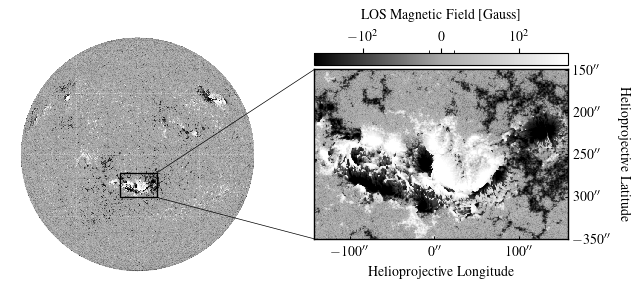

xmax, ymax, zmax 219.328 146.464 20.0
xmax_Mm, ymax_Mm, zmax_Mm 219.328 146.464 20.0
nresol_x, nresol_y, nresol_z 596 398 222
pixelsize_x, pixelsize_x_Mm 0.368 0.368
pixelsize_y, pixelsize_y_Mm 0.368 0.368
pixelsize_z, pixelsize_z_Mm 0.368 0.368


In [9]:
fig = plt.figure(figsize=(7.2, 4.8))
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax1 = fig.add_subplot(121, projection=magnetogram_big)
magnetogram_big.plot(
    axes=ax1,
    cmap=cmap,
    norm=norm,
    annotate=False,
)
magnetogram_big.draw_grid(axes=ax1, color="black", linestyle="dotted", lw=0.2)

for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)

magnetogram_big.draw_quadrangle(
    left_corner, top_right=right_corner, edgecolor="black", lw=1
)
magnetogram_small = hmi_image.submap(left_corner, top_right=right_corner)
ax2 = fig.add_subplot(122, projection=magnetogram_small)
im = magnetogram_small.plot(
    axes=ax2,
    norm=norm,
    cmap=cmap,
    annotate=False,
)
ax2.grid(alpha=0)

lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel(
    "Helioprojective Longitude",
)
lon.set_ticks_position("b")
lat.set_axislabel(
    "Helioprojective Latitude",
)
lat.set_axislabel_position("r")
lat.set_ticks_position("r")
lat.set_ticklabel_position("r")

xpix, ypix = magnetogram_big.wcs.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=0.5,
)
xpix, ypix = magnetogram_big.wcs.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame=magnetogram_big.coordinate_frame)
)
con2 = ConnectionPatch(
    (0, 0),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=0.5,
)
ax2.add_artist(con1)
ax2.add_artist(con2)

ax2.tick_params(direction="in", length=2, width=0.5)

pos = ax2.get_position().get_points()
cax = fig.add_axes([pos[0, 0], pos[1, 1] + 0.01, pos[1, 0] - pos[0, 0], 0.025])
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.locator = matplotlib.ticker.FixedLocator([-1e2, 0, 1e2])
cbar.set_label("LOS Magnetic Field [Gauss]", labelpad=-40, rotation=0)
cbar.update_ticks()
cbar.ax.xaxis.set_ticks_position("top")

plotname = "/Users/lilli/Desktop/Paper/SDO_observation.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

nresol_x = magnetogram_small.data.shape[1]
nresol_y = magnetogram_small.data.shape[0]

xmax_Mm = nresol_x * pixelsize_Mm
ymax_Mm = nresol_y * pixelsize_Mm
pixelsize_z_Mm = 90.0 * 10**-3

zmax_Mm = 20000.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

xmax = xmax_Mm
ymax = ymax_Mm
zmax = zmax_Mm
z0 = z0

pixelsize_x = pixelsize_Mm
pixelsize_y = pixelsize_Mm
pixelsize_z = pixelsize_Mm
print("xmax, ymax, zmax", xmax, ymax, zmax)
print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x, pixelsize_x_Mm", pixelsize_x, pixelsize_Mm)
print("pixelsize_y, pixelsize_y_Mm", pixelsize_y, pixelsize_Mm)
print("pixelsize_z, pixelsize_z_Mm", pixelsize_z, pixelsize_Mm)

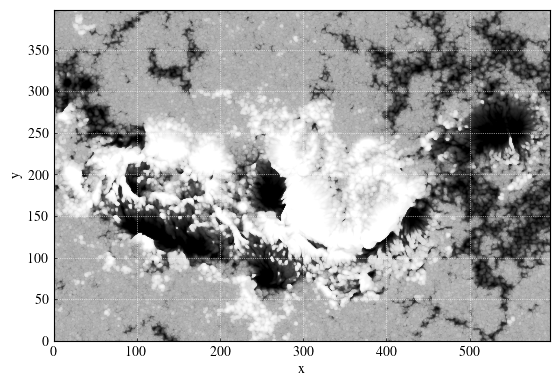

In [10]:
x_arr = np.arange(nresol_x) * (nresol_x) / (nresol_x - 1)
y_arr = np.arange(nresol_y) * (nresol_y) / (nresol_y - 1)
x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

fig = plt.figure()
ax = fig.add_subplot(111)
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax.grid(color="white", linestyle="dotted", linewidth=0.5)
ax.contourf(y_plot, x_plot, magnetogram_small.data, 1000, norm=norm, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tick_params(direction="in", length=2, width=0.5)
ax.set_box_aspect(ymax / xmax)
plotname = "/Users/lilli/Desktop/Colortests/color_test_magnetogram.png"
plt.savefig(plotname, dpi=300)
plt.show()

from mflex.classes.clsmod import DataBz

data = DataBz(
    magnetogram_small.data,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    nf_max,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    z0,
)

data_bz = data.data_z
x_arr = np.arange(2 * nresol_x) * (xmax - xmin) / (2 * nresol_x - 1) + xmin
y_arr = np.arange(2 * nresol_y) * (ymax - ymin) / (2 * nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

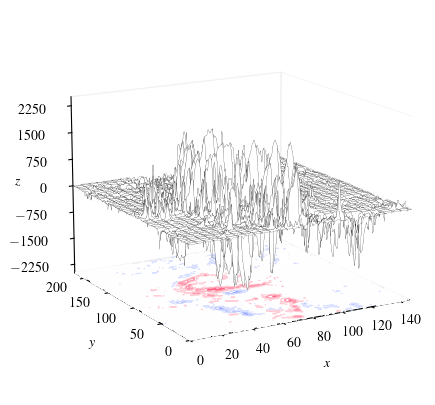

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cmap1",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#cmap=6B80FF-FFFFFF-FF3960
        (0.000, (0.420, 0.502, 1.000)),
        (0.500, (1.000, 1.000, 1.000)),
        (1.000, (1.000, 0.224, 0.376)),
    ),
)

x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
plt.subplots_adjust()

surf = ax.plot_surface(
    y_grid,
    x_grid,
    data_bz,
    edgecolor="black",
    lw=0.1,
    cstride=14,
    rstride=14,
    color="white",
    shade=False,
)
cset = ax.contour(
    y_grid, x_grid, data_bz, 6, linewidths=0.8, zdir="z", offset=-2500, cmap=cmap1
)
ax.clabel(cset, fontsize=5, inline=True)

ax.grid(False)

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")

[t.set_va("bottom") for t in ax.get_yticklabels()]
[t.set_ha("right") for t in ax.get_yticklabels()]

[t.set_va("center") for t in ax.get_xticklabels()]
[t.set_ha("center") for t in ax.get_xticklabels()]

[t.set_va("top") for t in ax.get_zticklabels()]
[t.set_ha("right") for t in ax.get_zticklabels()]

ax.xaxis._axinfo["tick"]["inward_factor"] = 0
ax.xaxis._axinfo["tick"]["outward_factor"] = -0.2
ax.yaxis._axinfo["tick"]["inward_factor"] = 0
ax.yaxis._axinfo["tick"]["outward_factor"] = -0.2
ax.zaxis._axinfo["tick"]["inward_factor"] = 0
ax.zaxis._axinfo["tick"]["outward_factor"] = -0.2

ax.xaxis.set_major_locator(MultipleLocator(20.0))
ax.yaxis.set_major_locator(MultipleLocator(50.0))
ax.zaxis.set_major_locator(MultipleLocator(750.0))

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(15, -120, 0)

ax.set_zlim(-2500, 2500)
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
plotname = "/Users/lilli/Desktop/Paper/SDO_contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [11]:
z0_b = z0
deltaz_b = z0 / 10.0
L = 1.0
# a = 0.2
# alpha = 0.008
b = 1.0

alpha = 0.0
a = 0.0

length_scale = float(2.0 * L)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x * L
length_scale_y = 2.0 * nresol_y * pixelsize_y * L

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

0.5


In [13]:
bfield = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(a)
    + "_"
    + str(alpha)
    + "_1.0_bfield3d.npy"
)

In [14]:
from mflex.plot.plot_magnetogram import (
    plot_fieldlines_sdo_paper,
    plot_fieldlines_sdo_paper_zoom,
)

x_arr = np.arange(2 * nresol_x) * (xmax - xmin) / (2 * nresol_x - 1) + xmin
y_arr = np.arange(2 * nresol_y) * (ymax - ymin) / (2 * nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

h1 = L / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = L  # Maximum step length for fieldline3D


In [15]:
bfield_lff = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(0.0)
    + "_"
    + str(0.0025)
    + "_1.0_bfield3d.npy"
)

bfield_mhs1 = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(0.2)
    + "_"
    + str(0.0025)
    + "_1.0_bfield3d.npy"
)


bfield_mhs2 = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(0.4)
    + "_"
    + str(0.0025)
    + "_1.0_bfield3d.npy"
)

In [ ]:
dbfield_lff = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(0.0)
    + "_"
    + str(0.0025)
    + "_1.0_dbzdxdydz3d.npy"
)

dbfield_mhs1 = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(0.2)
    + "_"
    + str(0.0025)
    + "_1.0_dbzdxdydz3d.npy"
)


dfield_mhs2 = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_"
    + str(0.4)
    + "_"
    + str(0.0025)
    + "_1.0_dbzdxdydz3d.npy"
)

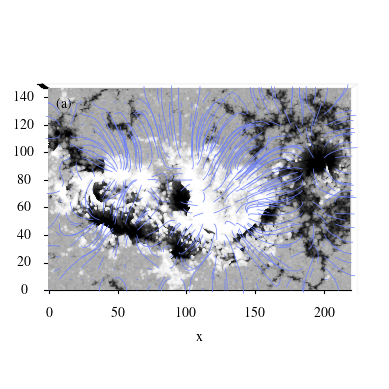

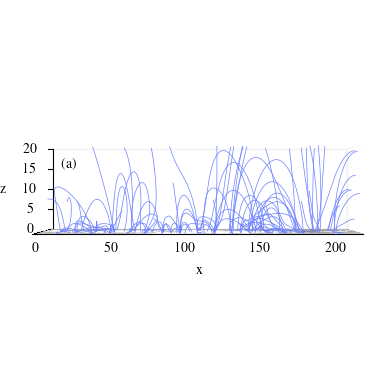

In [32]:
plot_fieldlines_sdo_paper(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.0,
    b,
    0.0,
    stepsize=8,
    view="top",
    cmap=cmap,
    name="(a)"
)

plot_fieldlines_sdo_paper(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.0,
    b,
    0.0,
    stepsize=12,
    view="side",
    cmap=cmap,
    name="(a)"
)

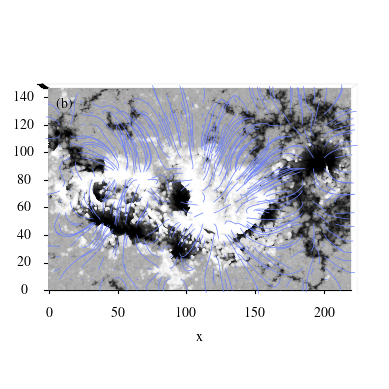

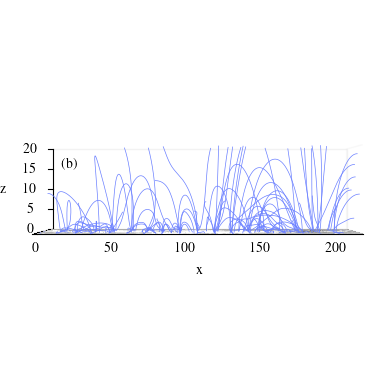

In [33]:
plot_fieldlines_sdo_paper(
    bfield_lff,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.0,
    b,
    0.0025,
    stepsize=8,
    view="top",
    cmap=cmap,
    name="(b)"
)

plot_fieldlines_sdo_paper(
    bfield_lff,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.0,
    b,
    0.0025,
    stepsize=12,
    view="side",
    cmap=cmap,
    name="(b)"
)

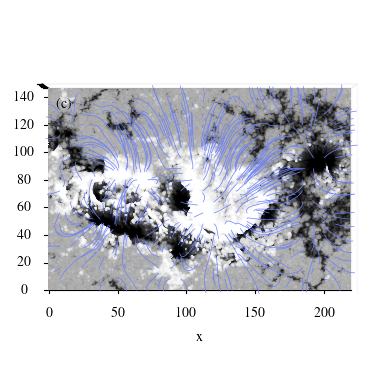

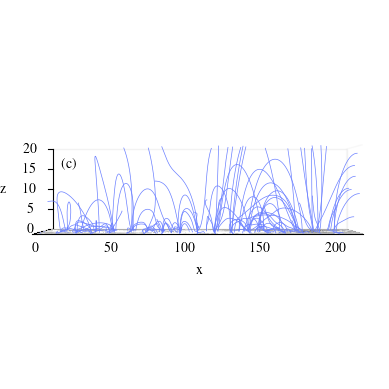

In [34]:
plot_fieldlines_sdo_paper(
    bfield_mhs1,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.2,
    b,
    0.0025,
    stepsize=8,
    view="top",
    cmap=cmap,
    name="(c)"
)

plot_fieldlines_sdo_paper(
    bfield_mhs1,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.2,
    b,
    0.0025,
    stepsize=12,
    view="side",
    cmap=cmap,
    name="(c)"
)

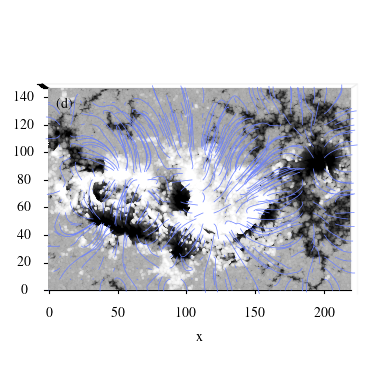

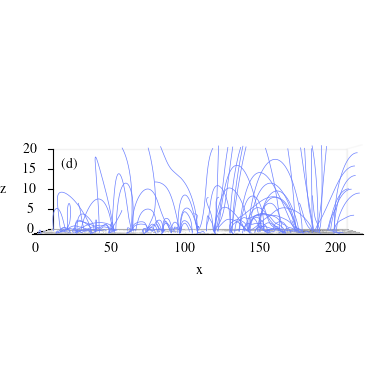

In [35]:
plot_fieldlines_sdo_paper(
    bfield_mhs2,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.4,
    b,
    0.0025,
    stepsize=8,
    view="top",
    cmap=cmap,
    name="(d)"
)

plot_fieldlines_sdo_paper(
    bfield_mhs2,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    0.4,
    b,
    0.0025,
    stepsize=12,
    view="side",
    cmap=cmap,
    name="(d)"
)

In [22]:
print(np.unravel_index(data_bz.argmax(), data_bz.shape))
ix_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[1]
iy_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[0]

(147, 307)


In [23]:
from mflex.model.plasma_parameters import (
    bpressure,
    bdensity,
    btemp,
    deltapres,
    deltaden,
    pres,
    den,
    btemp,
)

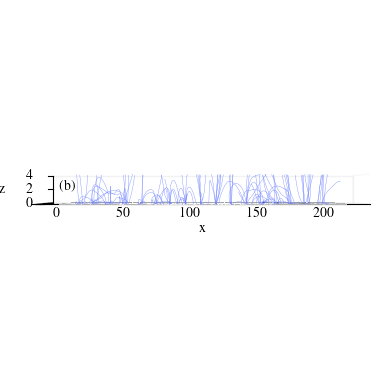

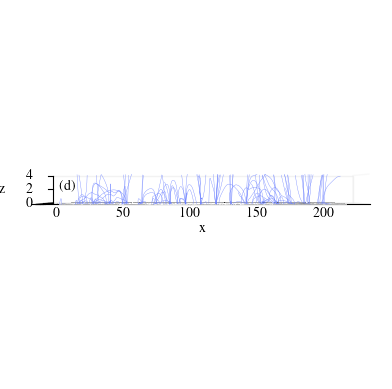

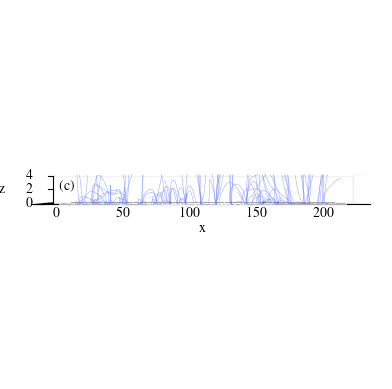

In [30]:
from mflex.plot.plot_magnetogram import (
    plot_fieldlines_sdo_paper,
    plot_fieldlines_sdo_paper_zoom,
)

plot_fieldlines_sdo_paper_zoom(
    bfield_lff,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    z0,
    0.0,
    b,
    0.0025,
    stepsize=12.0,
    view="side",
    cmap=cmap,
    name="(b)"
)

plot_fieldlines_sdo_paper_zoom(
    bfield_mhs2,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    z0,
    0.4,
    b,
    0.0025,
    stepsize=12.0,
    view="side",
    cmap=cmap,
    name="(d)"
)

plot_fieldlines_sdo_paper_zoom(
    bfield_mhs1,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    z0,
    0.2,
    b,
    0.0025,
    stepsize=12.0,
    view="side",
    cmap=cmap,
   name="(c)" 
)

In [36]:
dden_mhs2 = np.load("/Users/lilli/Desktop/Paper/dden_sdo_mhs.npy")
dpres_mhs2 = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_mhs.npy")

dden_mhs1 = np.load("/Users/lilli/Desktop/Paper/dden_sdo_mhs2.npy")
dpres_mhs1 = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_mhs2.npy")

dden_lff = np.load("/Users/lilli/Desktop/Paper/dden_sdo_lff.npy")
dpres_lff = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_lff.npy")

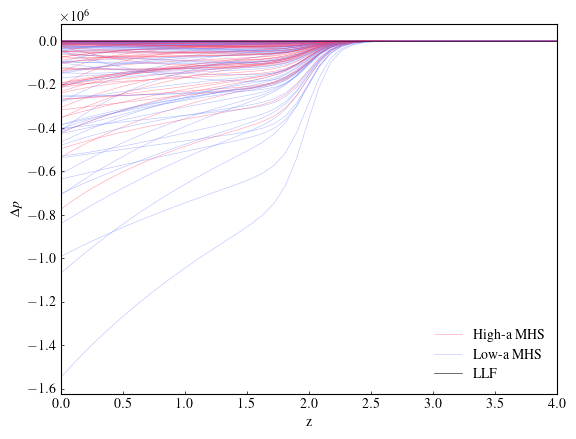

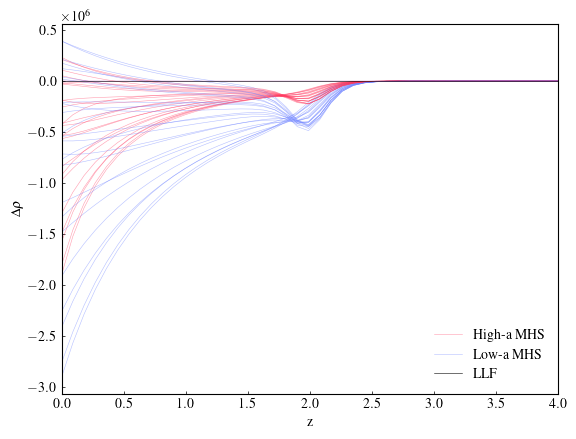

In [39]:
ix_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[1]
iy_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[0]

c4 = (1.000, 0.224, 0.376)

plt.plot(
    z_arr,
    dpres_mhs1[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c4,
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dpres_mhs2[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c2,
    alpha=0.5,
    label="Low-a MHS",
)
for ix in range(120, 307, 6):
    for iy in range(123, 148, 12):
        plt.plot(
            z_arr,
            dpres_mhs1[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c4,
            alpha=0.5,
        )
        plt.plot(
            z_arr,
            dpres_mhs2[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c2,
            alpha=0.5,
        )
plt.plot(
    z_arr,
    dpres_lff[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/SDO_dpres.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()


plt.plot(
    z_arr,
    dden_mhs1[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c4,
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dden_mhs2[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c2,
    alpha=0.5,
    label="Low-a MHS",
)
for ix in [278, 279, 280, 281, 282, 283]:
    for iy in [158, 159, 160, 161]:
        plt.plot(
            z_arr,
            dden_mhs1[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c4,
            alpha=0.5,
        )
        plt.plot(
            z_arr,
            dden_mhs2[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c2,
            alpha=0.5,
        )
plt.plot(
    z_arr,
    dden_lff[iy_max, ix_max, :],
    linewidth=0.4,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Paper/SDO_dden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()